# AADR metadata

## 0. Library and packages

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
.libPaths()

[1] "/maps/projects/racimolab/people/qxz396/miniconda3/envs/sNNt_slendr/lib/R/library"


In [3]:
%%R
.libPaths(c("/maps/projects/racimolab/people/qxz396/spaceNNtime/backup/environments/renv/library/R-4.1/x86_64-redhat-linux-gnu"))

In [4]:
%%R

library(tidyverse)
library(cowplot)
library(sf)
library(slendr)
library(rnaturalearth)
library(rnaturalearthdata)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Linking to GEOS 3.7.2, GDAL 3.0.4, PROJ 6.3.2; sf_use_s2() is TRUE

R[write to console]: You can setup a pre-configured environment with all of slendr's Python
tree-sequence dependencies (Python modules tskit, pyslim, and msprime)
by running the function setup_env().



## 1. Metadata import

In [5]:
%%bash

ls /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public.anno

/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public.anno


Because of the original formating of the file makes impossible to read directly by R, I need to reformat it changing some characters.

In [6]:
%%bash

sed 's/;/,,/g' /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public.anno \
    | sed 's/\t/;/g' \
    | sed 's/ /__/g' \
    | sed 's/;$//' \
    > /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno

Here are the original header

In [7]:
%%R

read.csv("/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno", header = T, sep = ";") %>%
    head() %>%
    names()

 [1] "Genetic__ID"                                                                                                                                                                                                                                                                                  
 [2] "Master__ID"                                                                                                                                                                                                                                                                                   
 [3] "Skeletal__code"                                                                                                                                                                                                                                                                               
 [4] "Skeletal__element"                                                                                                 

To make it easier to work with this dataset, I change the header

In [8]:
%%R

colnames <- c("indivi", "master", "foscod", "fosele", "yearpu", "public",
              "datmet", "datmea", "datstd", "datful", "agdead", "grouid",
              "locate", "countr", "latitu", "longit", "pulldo", "source",
              "numlib", "covera", "snps12", "snpsHO", "sexsex", "family", 
              "haply1", "haply2", "covemt", "haplmt", "matcmt", "damage", 
              "sexrat", "libtyp", "librar", "assess", "warnin")

read.csv("/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno", header = T, sep = ";", col.names = colnames) -> metadata

metadata %>% head()

                 indivi master
1 Ne30_genotyping_noUDG   NE30
2 Ne61_genotyping_noUDG   NE61
3 Ne35_genotyping_noUDG   NE35
4                I17622 I17622
5                I13833 I13833
6                 I3931  I3931
                                                  foscod             fosele
1                             AR9.9K_2d.rel.NE-4_deleted                 ..
2                                          AR3.4K_LowCov                 ..
3                                                 AR8.9K                 ..
4                     2637,,__Tumulus__1,__grave__?,__10     tooth__(molar)
5            1234,,__Tumulus__2,__grave__3,__ind.__1,__2            petrous
6 Aknashen__2014,__Trench__6,__UF__11,__F15,__L__humerus bone__(long__bone)
  yearpu                                 public
1   2021                          MaoFuCell2021
2   2021                          MaoFuCell2021
3   2021                          MaoFuCell2021
4   2022 LazaridisAlpaslanRoodenbergScience2022
5   2022 La

I first create a new column that identifies how the sample was dated with a simplified version compared to the original one. It is important to note that there are many belonging to the context which were dated because they were found with a directed dated bone, so, in a way, they could be considered to be directly dated as well. 

In [9]:
%%R

metadata %>% 
    mutate(datme2 = ifelse(str_detect(datmet, "^Direct"), "Direct", 
                          ifelse(str_detect(datmet, "^Context"), "Context", 
                                 ifelse(str_detect(datmet, "^context"), "Context",
                                        ifelse(str_detect(datmet, "^Layer__date__from__cattle__tooth"), "Context",
                                               ifelse(str_detect(datmet, "^Histroical"), "Context",
                                                      ifelse(str_detect(datmet, "^Modern"), "Modern", 
                                                             ifelse(str_detect(datmet, "^Known"), "Known", "Others")))))))) -> metadata

Now we can start exploring the metadata file and see what information is contained.

## 2. Coordinates information

I observed that there are 1778 samples with missing information about their location:

In [10]:
%%R

metadata %>%
    filter(longit == "..") %>%
    head(3)

        indivi   master   foscod fosele yearpu              public datmet
1   Altais1.SG  Altais1       ..     ..     .. DamgaardScience2018 Modern
2   Altais2.SG  Altais2       ..     ..     .. DamgaardScience2018 Modern
3 Ancestor.REF Ancestor Ancestor    n/a     ..     ReferenceGenome Modern
  datmea datstd  datful agdead       grouid locate countr latitu longit
1      0      0 present     .. Altaian_o.SG     .. Russia     ..     ..
2      0      0 present     ..   Altaian.SG     .. Russia     ..     ..
3      0      0 present     .. Ancestor.REF     ..     ..     ..     ..
                                     pulldo           source numlib    covera
1              Repulldown__on__3.2M__snpset          Shotgun     .. 20.254589
2              Repulldown__on__3.2M__snpset          Shotgun     .. 16.568944
3 1240K__pulldown__padded__to__3.2M__snpset Reference.Genome     ..        ..
   snps12 snpsHO sexsex                         family                haply1
1 1149196 592787      U n/a

In [11]:
%%R

metadata %>%
    filter(longit == "..") %>%
    nrow()

[1] 1787


And there is none with only information about latitude but not longitude and viceversa.

In [12]:
%%R

metadata %>%
    filter((longit == ".." & latitu != "..") | (longit != ".." & latitu == "..")) %>%
    nrow() 

[1] 0


There are a few master individuals (7) that have multiple samples in the dataset that at least one has info about location and the rest don't. All those samples are from "Modern". We can rescue those samples with the location information from the other samples.

In [13]:
%%R

metadata %>%
    mutate(locloc = ifelse(longit == "..", "nonloc", "locloc")) %>% 
    mutate(nn = 1) %>%
    spread(locloc, nn, fill = 0) %>%
    group_by(master) %>%
    mutate(n = n()) %>%
    mutate(nonloc = sum(nonloc), locloc = sum(locloc)) %>%
    ungroup() %>%
    filter(nonloc > 0 & locloc > 0) %>%
    as.data.frame() %>%
    arrange(master) %>%
    select(-c(fosele, yearpu, foscod, datstd, agdead, grouid, pulldo, family, haply1, haply2, covemt, haplmt, matcmt, damage, sexrat, libtyp, assess, source)) 

             indivi    master               public datmet datmea  datful locate
1        HG00174.SG   HG00174            1KGPhase3 Modern      0 present     ..
2    S_Finnish-1.DG   HG00174    MallickNature2016 Modern      0 present     ..
3        HG00174.DG   HG00174            1KGPhase3 Modern      0 present     ..
4        HG00190.SG   HG00190            1KGPhase3 Modern      0 present     ..
5    S_Finnish-2.DG   HG00190    MallickNature2016 Modern      0 present     ..
6        HG00190.DG   HG00190            1KGPhase3 Modern      0 present     ..
7       S_Esan-2.DG   HG02943    MallickNature2016 Modern      0 present     ..
8        HG02943.SG   HG02943            1KGPhase3 Modern      0 present     ..
9        HG02943.DG   HG02943            1KGPhase3 Modern      0 present     ..
10      S_Esan-1.DG   HG03100    MallickNature2016 Modern      0 present     ..
11       HG03100.SG   HG03100            1KGPhase3 Modern      0 present     ..
12       HG03100.DG   HG03100           

In [14]:
%%R

metadata %>%
    mutate(locloc = ifelse(longit == "..", "nonloc", "locloc")) %>% 
    mutate(nn = 1) %>%
    spread(locloc, nn, fill = 0) %>%
    mutate(longit = ifelse(longit == "..", -1000, longit),
           latitu = ifelse(latitu == "..", -1000, latitu)) %>%
    group_by(master) %>%
    mutate(nonloc = sum(nonloc), locloc = sum(locloc)) %>%
    mutate(longit = ifelse(nonloc > 0 & locloc > 0, max(longit), longit),
           latitu = ifelse(nonloc > 0 & locloc > 0, max(latitu), latitu)) %>%
    ungroup() %>%
    mutate(longit = ifelse(longit == -1000, "..", longit),
           latitu = ifelse(latitu == -1000, "..", latitu)) -> metadata

metadata %>%
    filter(nonloc > 0 & locloc > 0) %>%
    arrange(master) %>%
    as.data.frame() %>%
    select(-c(fosele, yearpu, foscod, datstd, agdead, grouid, pulldo, family, haply1, haply2, covemt, haplmt, matcmt, damage, sexrat, libtyp, assess, source)) 

             indivi    master               public datmet datmea  datful locate
1        HG00174.SG   HG00174            1KGPhase3 Modern      0 present     ..
2    S_Finnish-1.DG   HG00174    MallickNature2016 Modern      0 present     ..
3        HG00174.DG   HG00174            1KGPhase3 Modern      0 present     ..
4        HG00190.SG   HG00190            1KGPhase3 Modern      0 present     ..
5    S_Finnish-2.DG   HG00190    MallickNature2016 Modern      0 present     ..
6        HG00190.DG   HG00190            1KGPhase3 Modern      0 present     ..
7       S_Esan-2.DG   HG02943    MallickNature2016 Modern      0 present     ..
8        HG02943.SG   HG02943            1KGPhase3 Modern      0 present     ..
9        HG02943.DG   HG02943            1KGPhase3 Modern      0 present     ..
10      S_Esan-1.DG   HG03100    MallickNature2016 Modern      0 present     ..
11       HG03100.SG   HG03100            1KGPhase3 Modern      0 present     ..
12       HG03100.DG   HG03100           

In [15]:
%%R

metadata %>%
    select(-c(locloc, nonloc)) -> metadata

With the remaining samples, I check from which publication do they come from

In [16]:
%%R

metadata %>%
    filter(latitu == "..") %>%
    count(public) %>%
    arrange(n) %>%
    mutate(nn = sum(n),
           perc = round(n*100/nn, 2),
           public = substr(public, 0, 50)) %>%
    as.data.frame()

                                               public    n   nn  perc
1                   GnecchiRusconeScienceAdvances2021    1 1776  0.06
2                                 HajdinjakNature2018    1 1776  0.06
3                                  KumarFuScience2022    1 1776  0.06
4                    LamnidisNatureCommunications2018    1 1776  0.06
5                                   MafessoniPNAS2020    1 1776  0.06
6                                   MallickNature2016    1 1776  0.06
7                                      Not__published    1 1776  0.06
8                                 PattersonNature2021    1 1776  0.06
9                                     ReferenceGenome    1 1776  0.06
10                               BergstromScience2020    2 1776  0.11
11                           FernandesSirakNature2020    2 1776  0.11
12 FregelPNAS2018__(merge.of.two.published.samplesfro    2 1776  0.11
13                                             Genome    3 1776  0.17
14                  

In [17]:
%%R

metadata %>%
    filter(latitu == "..",
           public == "1KGPhase3") %>%
    head() %>%
    as.data.frame()

      indivi  master foscod fosele yearpu    public datmet datmea datstd
1 NA20278.SG NA20278     ..     ..     .. 1KGPhase3 Modern      0      0
2 NA19625.SG NA19625     ..     ..     .. 1KGPhase3 Modern      0      0
3 NA19921.SG NA19921     ..     ..     .. 1KGPhase3 Modern      0      0
4 NA20274.SG NA20274     ..     ..     .. 1KGPhase3 Modern      0      0
5 NA20299.SG NA20299     ..     ..     .. 1KGPhase3 Modern      0      0
6 NA20314.SG NA20314     ..     ..     .. 1KGPhase3 Modern      0      0
   datful agdead                 grouid            locate countr latitu longit
1 present     ..       ASW_oEuropean.SG African-Americans    USA     ..     ..
2 present     .. ASW_oNativeAmerican.SG African-Americans    USA     ..     ..
3 present     .. ASW_oNativeAmerican.SG African-Americans    USA     ..     ..
4 present     .. ASW_oNativeAmerican.SG African-Americans    USA     ..     ..
5 present     .. ASW_oNativeAmerican.SG African-Americans    USA     ..     ..
6 present     .

I can see that most of the samples without location information are actually from 1KGPhase3. I will try to get access to that information myself. 

In the IGSR portal (https://www.internationalgenome.org/data-portal/sample), I went to the data-portal and extracted information individuals and populations of 1KGPhase3. I can download them and transfer to the cluster.

In [18]:
%%R

read.csv("../../files/igsr_1KGPhase3_populations.tsv", header = T, sep = "\t") %>%
    select(-c(Data.collections, Superpopulation.name, Superpopulation.display.colour, Population.description, Superpopulation.display.order, Population.name, Population.elastic.ID)) %>%
    head()

  Population.code Population.latitude Population.longitude Superpopulation.code
1             FIN            60.17000              24.9300                  EUR
2             CHS            23.13333             113.2667                  EAS
3             KHV            10.78000             106.6800                  EAS
4             BEB            23.70000              90.3500                  SAS
5             PUR            18.40000             -66.1000                  AMR
6             ACB            13.10000             -59.6200                  AFR


In [19]:
%%R

read.csv("../../files/igsr_1KGPhase3_samples.tsv", header = T, sep = "\t") %>%
    select(-c(Data.collections, Superpopulation.code, Superpopulation.name, Population.elastic.ID)) %>%
    head()

  Sample.name    Sex Biosample.ID Population.code Population.name
1     HG00271   male   SAME123417             FIN         Finnish
2     HG00276 female   SAME123424             FIN         Finnish
3     HG00288 female  SAME1839246             FIN         Finnish
4     HG00290   male  SAME1839057             FIN         Finnish
5     HG00308   male   SAME124161             FIN         Finnish
6     HG00310   male   SAME124338             FIN         Finnish


In [20]:
%%R

read.csv("../../files/igsr_1KGPhase3_populations.tsv", header = T, sep = "\t") %>%
    select(pop = Population.code, lon = Population.longitude, lat = Population.latitude) %>%
    right_join(read.csv("../../files/igsr_1KGPhase3_samples.tsv", header = T, sep = "\t") %>%
                    select(master = Sample.name, pop = Population.code), by = c("pop")) %>%
    select(master, lat, lon) -> igsr_1KGPhase3_loc
    
head(igsr_1KGPhase3_loc)

   master   lat   lon
1 HG00271 60.17 24.93
2 HG00276 60.17 24.93
3 HG00288 60.17 24.93
4 HG00290 60.17 24.93
5 HG00308 60.17 24.93
6 HG00310 60.17 24.93


then, I can join this information with the AADR metadata.

In [21]:
%%R

metadata %>%
    left_join(igsr_1KGPhase3_loc, by = c("master")) %>%
    mutate(latitu = ifelse(latitu == ".." & !is.na(lat), lat, latitu),
           longit = ifelse(longit == ".." & !is.na(lon), lon, longit)) -> metadata

So, we can see that now we recovered the 1KGPhase3 samples, but 2

In [22]:
%%R

metadata %>%
    filter(latitu == "..") %>%
    count(public) %>%
    arrange(n) %>%
    mutate(nn = sum(n),
           perc = round(n*100/nn, 2),
           public = substr(public, 0, 50)) %>%
    as.data.frame()

                                               public  n  nn  perc
1                   GnecchiRusconeScienceAdvances2021  1 206  0.49
2                                 HajdinjakNature2018  1 206  0.49
3                                  KumarFuScience2022  1 206  0.49
4                    LamnidisNatureCommunications2018  1 206  0.49
5                                   MafessoniPNAS2020  1 206  0.49
6                                   MallickNature2016  1 206  0.49
7                                      Not__published  1 206  0.49
8                                 PattersonNature2021  1 206  0.49
9                                     ReferenceGenome  1 206  0.49
10                                          1KGPhase3  2 206  0.97
11                               BergstromScience2020  2 206  0.97
12                           FernandesSirakNature2020  2 206  0.97
13 FregelPNAS2018__(merge.of.two.published.samplesfro  2 206  0.97
14                                             Genome  3 206  

And these are two Spanish samples which don't have the location information.

In [23]:
%%R

metadata %>%
    filter(latitu == "..", public == "1KGPhase3") %>%
    as.data.frame()

      indivi  master foscod fosele yearpu    public datmet datmea datstd
1 HG01783.SG HG01783     ..     ..     .. 1KGPhase3 Modern      0      0
2 HG01783.DG HG01783     ..     ..     .. 1KGPhase3 Modern      0      0
   datful agdead grouid            locate countr latitu longit
1 present     .. IBS.SG Castilla__y__Leon  Spain     ..     ..
2 present     .. IBS.DG Castilla__y__Leon  Spain     ..     ..
                                     pulldo          source numlib covera
1 1240K__pulldown__padded__to__3.2M__snpset         Shotgun     ..     ..
2 1240K__pulldown__padded__to__3.2M__snpset Shotgun.diploid     ..     ..
   snps12 snpsHO sexsex                         family haply1 haply2 covemt
1 1148732 592763      M n/a__(no__relatives__detected)     ..     ..     ..
2  858511 430590      M n/a__(no__relatives__detected)     ..     ..     ..
  haplmt matcmt damage sexrat libtyp librar
1     ..     ..     ..     ..     ..     ..
2     ..     ..     ..     ..     ..     ..
          

In [24]:
%%R

igsr_1KGPhase3_loc %>%
    filter(is.na(lat))

   master lat lon
1 HG01783  NA  NA


In [25]:
%%R

read.csv("../../files/igsr_1KGPhase3_populations.tsv", header = T, sep = "\t") %>%
    filter(is.na(Population.latitude))

 [1] Population.code                Population.elastic.ID         
 [3] Population.name                Population.description        
 [5] Population.latitude            Population.longitude          
 [7] Superpopulation.code           Superpopulation.name          
 [9] Superpopulation.display.colour Superpopulation.display.order 
[11] Data.collections              
<0 rows> (or 0-length row.names)


In [26]:
%%R

read.csv("../../files/igsr_1KGPhase3_samples.tsv", header = T, sep = "\t") %>%
    filter(Sample.name == "HG01783")

  Sample.name  Sex Biosample.ID Population.code Population.name
1     HG01783 male   SAME124427         IBS,MSL   Iberian,Mende
  Superpopulation.code               Superpopulation.name Population.elastic.ID
1              EUR,AFR European Ancestry,African Ancestry               IBS,MSL
                                                                Data.collections
1 1000 Genomes on GRCh38,1000 Genomes 30x on GRCh38,1000 Genomes phase 3 release


This is because the individual seems to have annotated two ancestries and thus, is admixed. We can drop this sample.

I finally drop all those samples for which I don't have info about the geographical coordinates

In [27]:
%%R

metadata %>%
    filter(latitu != "..") %>%
    ungroup() -> metadata

## 3. Dating method, multiple samples per master and assessment filters

How many samples belong to each method of dating category and from each, how many are repeated multiple times

In [28]:
%%R

#legend:
#   - n   : number of times an individual is repeated
#   - nn  : number of master labels are repeated n times
#   - nnn : number of rows correspond to each number of n repeated entries

metadata %>% 
    group_by(master, datme2) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    group_by(datme2, n) %>%
    summarize(nn = n()) %>%
    mutate(nnn = n*nn) %>%
    mutate(percin = round(nnn/sum(nnn)*100, 3)) %>%
    ungroup() %>%
    mutate(perc = round(nnn/sum(nnn)*100, 3))

`summarise()` has grouped output by 'master'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'datme2'. You can override using the
`.groups` argument.
# A tibble: 12 × 6
   datme2      n    nn   nnn  percin   perc
   <chr>   <int> <int> <int>   <dbl>  <dbl>
 1 Context     1  4517  4517  96.4   27.8  
 2 Context     2    69   138   2.94   0.849
 3 Context     3    11    33   0.704  0.203
 4 Direct      1  4780  4780  90.2   29.4  
 5 Direct      2   219   438   8.27   2.69 
 6 Direct      3    20    60   1.13   0.369
 7 Direct      4     4    16   0.302  0.098
 8 Direct      5     1     5   0.094  0.031
 9 Known       1     6     6 100      0.037
10 Modern      1   958   958  15.3    5.89 
11 Modern      2  2624  5248  83.8   32.3  
12 Modern      3    20    60   0.958  0.369


I can see that for: 
   + Context = \~3% (\~1% of the total)
   + Direct = \~10% (\~3% of the total)
   + Modern = \~85% (\~31% of the total)

of samples are repeated more than once. This amounts to 35% of the total data set is composed of individuals repeated multiple times.

There is another column which should be used for filtering the data: "assess". This is some sort of assessment done per sample which tells us if a sample should be included in analysis or not. Because my intention is to use these samples to learn dating and localizing, it is important that they are of good quality. 

In [29]:
%%R

metadata %>% 
    group_by(master) %>%
    mutate(rep = n()) %>%
    ungroup() %>%
    mutate(haspass = ifelse(str_detect(assess, "PASS"), 1, 2)) %>%
    mutate(haspass = ifelse(assess == "PASS", 0, haspass)) %>%
    group_by(rep, assess, haspass) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    mutate(perc = round(100*n/sum(n), 2)) %>%
    arrange(haspass, n) %>%
    mutate(assess = substr(assess, 0, 40)) %>%
    group_by(haspass) %>%
    mutate(tothaspas = sum(perc)) %>%
    ungroup() %>%
    as.data.frame() %>%
    print()

`summarise()` has grouped output by 'rep', 'assess'. You can override using the
`.groups` argument.
   rep                                   assess haspass    n  perc tothaspas
1    5                                     PASS       0    5  0.03     80.67
2    4                                     PASS       0   13  0.08     80.67
3    3                                     PASS       0  120  0.74     80.67
4    2                                     PASS       0 3225 19.84     80.67
5    1                                     PASS       0 9752 59.98     80.67
6    1                         PROVISIONAL_PASS       1    1  0.01     16.34
7    2 PASS_make.damage.restricted.versions.to.       1    1  0.01     16.34
8    3                 PROVISIONAL_PASS_ADDBACK       1    1  0.01     16.34
9    4 PASS_WHY_COV_LESS_THAN_UDG_FULLY_TREATED       1    1  0.01     16.34
10   1                 PROVISIONAL_PASS_ADDBACK       1    2  0.01     16.34
11   2                               MERGE_PASS      

A big proportion of the data is flagged with the assessment PASS (80%) which is good. A big proportion of those are composed of samples that are repeated (25%) but most of those will be recovered. 

16% of the data has the flag PASS with some other annotation. >90% of those have the flag "PASS_MAYBE_REPLACE_IN_FUTURE_WITH_LESS_FILTERED_VERSION_WITH_MORE_SNPS_COVERED". The rest look ok, and since most of them are repeated multiple times, there is a good chance that the repeated version will have a PASS flag. So, I'll include those samples as well. 

Only a 3% of samples have a undesirable assessment flag. These are going to be dropped. 

In [30]:
%%R

metadata %>% 
    mutate(asses2 = ifelse(str_detect(assess, "PASS"), "semiPASS", "FAIL")) %>%
    mutate(asses2 = ifelse(assess == "PASS", "PASS", asses2)) %>%
    group_by(datme2, asses2) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    group_by(datme2) %>%
    mutate(percdatme2 = n/sum(n)*100) %>%
    ungroup() %>%
    group_by(asses2) %>%
    mutate(percasses2 = n/sum(n)*100) %>%
    ungroup() %>%
    mutate(perc = n/sum(n)*100)

`summarise()` has grouped output by 'datme2'. You can override using the
`.groups` argument.
# A tibble: 9 × 6
  datme2  asses2       n percdatme2 percasses2    perc
  <chr>   <chr>    <int>      <dbl>      <dbl>   <dbl>
1 Context FAIL       250      5.33     51.1     1.54  
2 Context PASS      4399     93.8      33.5    27.1   
3 Context semiPASS    39      0.832     1.47    0.240 
4 Direct  FAIL       239      4.51     48.9     1.47  
5 Direct  PASS      4946     93.3      37.7    30.4   
6 Direct  semiPASS   114      2.15      4.29    0.701 
7 Known   PASS         6    100         0.0457  0.0369
8 Modern  PASS      3764     60.1      28.7    23.2   
9 Modern  semiPASS  2502     39.9      94.2    15.4   


Looking at the percentage of the data that belongs to each assessment category, it seems that all the FAIL flags belong to samples dated by Context and Directly dated (50-50). Moreover, the semiPASS, which are flags with the code "PASS" with some other annotation, almost all belong to the modern data. For the PASS samples, they are equally divided between Context, Direct and Modern. 

Looking at the percentage of data that belong to each dating method category, we can see that most of the Context and Direct have passed (>93%). For the Modern is 2/3 pass and 1/3 in semi passed.

Now, I'll check between the dating method the assessment and the number of times the the sample is repeated. 

In [31]:
%%R

#legend:
#   - n   : number of times an individual is repeated
#   - nn  : number of master labels are repeated n times
#   - nnn : number of rows correspond to each number of n repeated entries

metadata %>% 
    mutate(asses2 = ifelse(assess == "PASS", TRUE, FALSE)) %>%
    group_by(master, asses2, datme2) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    group_by(datme2, asses2, n) %>%
    summarize(nn = n()) %>%
    mutate(nnn = n*nn) %>%
    mutate(perc = round(nnn/sum(nnn)*100, 3))

`summarise()` has grouped output by 'master', 'asses2'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'datme2', 'asses2'. You can override using
the `.groups` argument.
# A tibble: 17 × 6
# Groups:   datme2, asses2 [7]
   datme2  asses2     n    nn   nnn    perc
   <chr>   <lgl>  <int> <int> <int>   <dbl>
 1 Context FALSE      1   285   285  98.6  
 2 Context FALSE      2     2     4   1.38 
 3 Context TRUE       1  4290  4290  97.5  
 4 Context TRUE       2    44    88   2    
 5 Context TRUE       3     7    21   0.477
 6 Direct  FALSE      1   324   324  91.8  
 7 Direct  FALSE      2    13    26   7.36 
 8 Direct  FALSE      3     1     3   0.85 
 9 Direct  TRUE       1  4587  4587  92.7  
10 Direct  TRUE       2   152   304   6.15 
11 Direct  TRUE       3    14    42   0.849
12 Direct  TRUE       4     2     8   0.162
13 Direct  TRUE       5     1     5   0.101
14 Known   TRUE       1     6     6 100    
15 Modern  FALSE      1  2502  2502 100 

In [32]:
%%R

#legend:
#   - n   : number of times an individual is repeated
#   - nn  : number of master labels are repeated n times
#   - nnn : number of rows correspond to each number of n repeated entries

metadata %>% 
    mutate(asses2 = ifelse(str_detect(assess, "PASS"), "semiPASS", "FAIL")) %>%
    mutate(asses2 = ifelse(assess == "PASS", "PASS", asses2)) %>%
    select(master, datme2, asses2) %>%
    group_by(master, datme2, asses2) %>%
    summarize(n = n()) %>%
    spread(asses2, n, fill = 0) %>%
    mutate(TOTAL = FAIL+PASS+semiPASS) %>%
    ungroup() %>%
    group_by(datme2, FAIL, PASS, semiPASS, TOTAL) %>%
    summarize(n = n()) %>%
    arrange(datme2, TOTAL) %>%
    as.data.frame()

`summarise()` has grouped output by 'master', 'datme2'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'datme2', 'FAIL', 'PASS', 'semiPASS'. You
can override using the `.groups` argument.
    datme2 FAIL PASS semiPASS TOTAL    n
1  Context    0    0        1     1   29
2  Context    0    1        0     1 4263
3  Context    1    0        0     1  225
4  Context    0    1        1     2    8
5  Context    0    2        0     2   40
6  Context    1    0        1     2    1
7  Context    1    1        0     2   19
8  Context    2    0        0     2    1
9  Context    0    2        1     3    1
10 Context    0    3        0     3    7
11 Context    1    2        0     3    3
12  Direct    0    0        1     1   82
13  Direct    0    1        0     1 4525
14  Direct    1    0        0     1  173
15  Direct    0    0        2     2    2
16  Direct    0    1        1     2   25
17  Direct    0    2        0     2  145
18  Direct    1    1        0     2   

In [33]:
%%R

metadata %>%
    filter(datme2 == "Others") %>%
    as.data.frame() %>%
    select(-c(foscod, datful, agdead, family))

 [1] indivi master fosele yearpu public datmet datmea datstd grouid locate
[11] countr latitu longit pulldo source numlib covera snps12 snpsHO sexsex
[21] haply1 haply2 covemt haplmt matcmt damage sexrat libtyp librar assess
[31] warnin datme2 lat    lon   
<0 rows> (or 0-length row.names)


In [34]:
%%R

metadata %>%
    filter(master == "I1877") %>%
    select(-c(foscod, public, datmet, datful, agdead, family))

# A tibble: 2 × 32
  indivi   master fosele yearpu datmea datstd grouid locate countr latitu longit
  <chr>    <chr>  <chr>  <chr>   <int>  <int> <chr>  <chr>  <chr>  <chr>  <chr> 
1 I1877_n… I1877  petro… 2017     7567     39 Hunga… Alson… Hunga… 46.20… 18.70…
2 I1877_v… I1877  petro… 2017     7567     39 Hunga… Alson… Hunga… 46.20… 18.70…
# … with 21 more variables: pulldo <chr>, source <chr>, numlib <chr>,
#   covera <chr>, snps12 <int>, snpsHO <int>, sexsex <chr>, haply1 <chr>,
#   haply2 <chr>, covemt <chr>, haplmt <chr>, matcmt <chr>, damage <chr>,
#   sexrat <chr>, libtyp <chr>, librar <chr>, assess <chr>, warnin <chr>,
#   datme2 <chr>, lat <dbl>, lon <dbl>


I will do the following filter:
    1. Remove samples that have a FAIL assessment
    2. If a master sample has UDG treated samples, keep those and drop the noUDG treated samples. Otherwise, keep the noUDG treated.
    3. If there are samples that are not SG (single read genotyping), keep those, otherwise, keep the SG.
    4. If there are still multiple samples for a given master sample, keep the sample with higher number of 1240K SNPs genotyped

In [35]:
%%R

metadata %>% 
    #1. MUTATE: Create a variable that counts how many samples each master sample has
    group_by(master) %>% 
    mutate(n = n()) %>%
    ungroup() %>%
    
    #2. MUTATE: Create 3 variables that has information about about how many FAIL, PASS and semiPASS samples with the same master ID the sample has
    mutate(asses2 = ifelse(str_detect(assess, "PASS"), "semiPASS", "FAIL")) %>% 
    mutate(asses2 = ifelse(assess == "PASS", "PASS", asses2)) %>%
    mutate(asses3 = asses2) %>%

    mutate(nn = 1) %>%
    spread(asses2, nn, fill = 0) %>%
    group_by(master) %>%
    mutate(FAIL = sum(FAIL), PASS = sum(PASS), semiPASS = sum(semiPASS)) %>%
    ungroup() %>%
    
    #3. FILTER: Remove failed samples
    filter(asses3 != "FAIL") %>%
    
    #4. MUTATE : Create a variable that has information about UDG treatment
    mutate(UDGtre = ifelse(str_detect(indivi, "noUDG"), "noUDG", "UDG"),
           UDGtr2 = UDGtre) %>%
    mutate(nn = 1) %>%
    spread(UDGtre, nn, fill = 0) %>%
    group_by(master) %>%
    mutate(noUDG = sum(noUDG), UDG = sum(UDG)) %>%
    ungroup() %>%
    
    #5. FILTER: if master samples have UDG and noUDG treated samples, filter out noUDG treated ones
    filter((UDG == 0 & UDGtr2 == "noUDG") | (UDG > 0 & UDGtr2 == "UDG")) %>%
    
    
    #6. MUTATE : Create a variable that has information about SNP calling
    #  SG=samples with whole genome shotgun sequence data, randomly drawing a single read to represent each position in the genome
    #  DG=samples shotgun sequenced with high enough coverage to call diploid genotypes, allowing for heterozygous calls
    mutate(SGDGNG = ifelse(str_detect(indivi, "\\.DG"), "DG", 
                          ifelse(str_detect(indivi, "\\.SG"), "SG", "NG")),
           SGDGNG2 = SGDGNG) %>%
    mutate(nn = 1) %>%
    spread(SGDGNG, nn, fill = 0) %>%
    group_by(master) %>%
    mutate(DG = sum(DG), SG = sum(SG), NG = sum(NG)) %>%
    ungroup() %>%
    
    #7. FILTER: if master samples have UDG and noUDG treated samples, filter out noUDG treated ones
    filter((DG+NG == 0 & SGDGNG2 == "SG") | (DG+NG > 0 & SGDGNG2 != "SG")) %>%
    
    #8. FILTER : 1240K coverage
    group_by(master) %>%
    filter(snps12 == max(snps12)) %>%
    ungroup() %>%
       
    #4. arrange and filter data
    arrange(master) -> metadata_unique
    
metadata_unique %>%
    as.data.frame() %>%
    head(10)
    

                 indivi   master                    foscod            fosele
1  s19_0LS03_1_noUDG.SG    0LS03       TÜ__1977:__matus__9    tooth__(molar)
2  s19_0LS09_1_noUDG.SG    0LS09 AI__6009:__L180,__Cist__1 tooth__(premolar)
3  s19_0LS10_1_noUDG.SG    0LS10           TÜ__1325:__L777 tooth__(premolar)
4  s19_0LS11_1_noUDG.SG    0LS11       AI__5306:__kogum__1 tooth__(premolar)
5             11KBM1.SG   11KBM1                    11KBM1             Tooth
6     18R21262_noUDG.EC 18R21262                  18R21262              bone
7     18R21265_noUDG.EC 18R21265                  18R21265   bone__(cranial)
8        19651_noUDG.SG    19651                     19651                ..
9               1H04.SG     1H04          1H04_Ages_2_7162             tooth
10              1H06.SG     1H06          1H06_Ages_2_7163             tooth
   yearpu                   public
1    2019   SaagCurrentBiology2019
2    2019   SaagCurrentBiology2019
3    2019   SaagCurrentBiology2019
4    2019   S

There are no remaining master samples with multiple samples.

In [36]:
%%R

metadata_unique %>%
    count(master) %>%
    filter(n > 1)

# A tibble: 0 × 2
# … with 2 variables: master <chr>, n <int>


In [37]:
%%bash

ls ../../files/v54.1_1240K_public_reformated.anno

../../files/v54.1_1240K_public_reformated.anno


## 4. Write metadata

In [38]:
%%R

metadata_unique %>%
    select(-c(lat, lon, n, asses3, FAIL, PASS, semiPASS, UDGtr2, noUDG, UDG, SGDGNG2, DG, NG, SG)) %>%
    write.table("../../files/AADR_filtered_metadata.txt", sep = "\t", quote = FALSE, row.names = FALSE)

## 5. Summary Plots

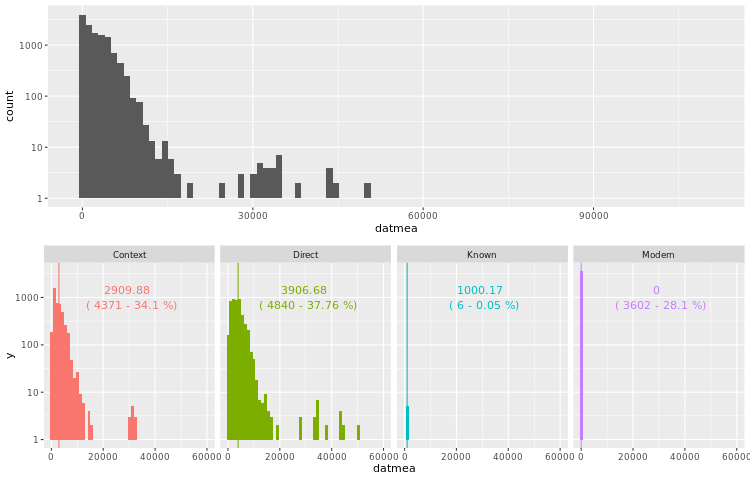

In [39]:
%%R -w 750

plot_grid(
    metadata_unique %>% 
        select(master, datme2, datmea) %>%
        distinct() %>%
        ggplot() +
        geom_histogram(aes(x = datmea), bins = 100) +
        scale_y_log10(), 
    metadata_unique %>% 
        select(master, datme2, datmea) %>%
        distinct() %>%
        ggplot() +
        geom_histogram(aes(x = datmea, fill = datme2), bins = 100, show.legend = F) +
        geom_vline(data = . %>% group_by(datme2) %>% summarize(mean = mean(datmea)), 
                   aes(xintercept = mean, color = datme2), show.legend = F) +
        geom_text(data = . %>% group_by(datme2) %>% summarize(mean = mean(datmea), n = n()) %>% mutate(perc = round(n*100/sum(n), 2)), 
                  aes(x = 30000, y = 1000, label = paste(round(mean, 2), "\n (", n, "-", perc, "%)"), color = datme2), show.legend = F) +
        coord_cartesian(xlim = c(0, 60000)) +
        scale_y_log10() +
        facet_wrap(.~datme2, nrow = 1), nrow = 2, align = "v")

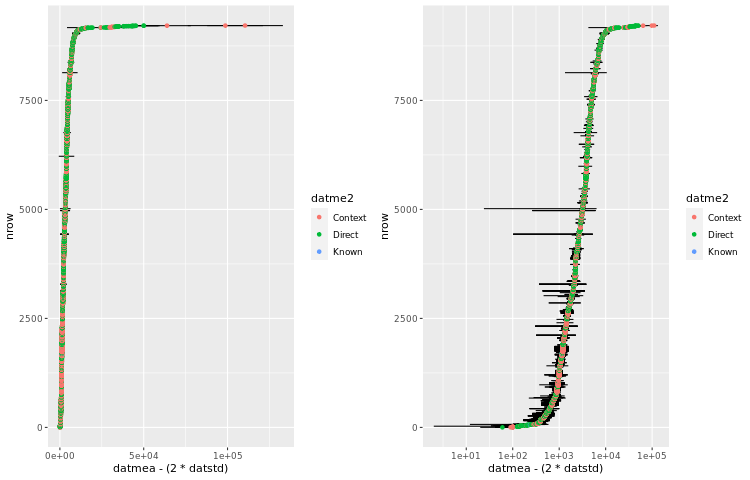

In [40]:
%%R -w 750

plot_grid(
    metadata_unique %>% 
        filter(datme2 != "Modern") %>%
        arrange(datmea) %>%
        mutate(nrow = 1:n()) %>%
        ggplot() +
        geom_segment(aes(x = datmea-(2*datstd), xend = datmea+(2*datstd), y = nrow, yend = nrow)) +
        geom_point(aes(y = nrow, x = datmea, color = datme2)),

    metadata_unique %>% 
        filter(datme2 != "Modern") %>%
        arrange(datmea) %>%
        mutate(nrow = 1:n()) %>%
        ggplot() +
        geom_segment(aes(x = datmea-(2*datstd), xend = datmea+(2*datstd), y = nrow, yend = nrow)) +
        geom_point(aes(y = nrow, x = datmea, color = datme2)) +
        scale_x_log10(),

    nrow = 1)

In [41]:
%%R

metadata_unique %>%
    filter(datme2 != "Modern") %>%
    pull(datmea) %>%
    quantile()

    0%    25%    50%    75%   100% 
    60   1392   2850   4430 110450 


In [ ]:
%%R -w 1500 -h 750

map_plot <- function(mintim, maxtim, datmef){
    metadata_unique %>% 
        filter(datmea >= mintim, datmea < maxtim, datme2 == datmef) %>%
        mutate(latitu = as.numeric(as.character(latitu)),
               longit = as.numeric(as.character(longit))) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = longit, y = latitu, color = datmea)) +
        xlab("Longitude (º)") +
        ylab("Latitude (º)") +
        theme_bw()
}

plot_grid(map_plot(0, 1, "Modern"),  map_plot(60, 1392, "Modern"),  map_plot(1392, 2850, "Modern"),  map_plot(2850, 4430, "Modern"),  map_plot(4430, 120000, "Modern"),
          map_plot(0, 1, "Direct"),  map_plot(60, 1392, "Direct"),  map_plot(1392, 2850, "Direct"),  map_plot(2850, 4430, "Direct"),  map_plot(4430, 120000, "Direct"),
          map_plot(0, 1, "Context"), map_plot(60, 1392, "Context"), map_plot(1392, 2850, "Context"), map_plot(2850, 4430, "Context"), map_plot(4430, 120000, "Context"),
         nrow = 3)

In [ ]:
%%R

map_plot(60, 1392, "Direct")
